In [36]:
import random
import pickle
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import cycle

In [37]:
### TO DO
# 1) Randomize '(?)' nodes
# 2) Saving final traces to pkl/json


In [38]:
# Trace builiding code
class Trace:
    def __init__(self):
        self.calls = []

class Node_info:
    def __init__(self, num_id, n_type):
        self.num_id = num_id
        self.n_type = n_type

class Call:
    def __init__(self, traceid, timestamp, rpcid, um, dm, rpctype, interface, rt):
        self.traceid = traceid
        self.timestamp = timestamp
        self.rpcid = rpcid
        self.um = um
        self.dm = dm 
        self.rpctype = rpctype
        self.interface = interface
        self.rt = rt
    def string(self):
        return self.traceid + "," + str(self.timestamp) + "," + self.rpcid + "," + self.um + "," + self.dm + "," +\
            self.rpctype + "," + self.interface + "," + str(self.rt)

def csv_to_df(file: str):
    use_columns = list(range(9)) 
    df = pd.read_csv(file,delimiter=',', usecols=use_columns)
    return df

def extract_traceid_rows(df, tid):
    '''
    Returns a list of rpc calls in tid
    '''
    f_df = df[df['traceid'] == tid]
    tid_calls = [
        Call(
            str(row.traceid), 
            int(row.timestamp), 
            str(row.rpcid), 
            str(row.um), 
            str(row.dm), 
            str(row.rpctype), 
            str(row.interface), 
            int(row.rt)
        ) for row in f_df.itertuples(index=False)
    ]
    return tid_calls

def get_call_depth(rpc_id):
    if rpc_id == "0":
        return 1
    else:
        call_depth = 0
        for i in rpc_id:
            if i == ".":
                call_depth += 1
    return call_depth


In [75]:
# types :  ['userDefined', 'db', 'http', 'mq', 'rpc', 'mc']
# Extract to dataframe
df = csv_to_df("./casper_rebuild.csv")

# Extract all tids
tids_list = df['traceid'].unique().tolist()
unique_nodes = list(set(df['um'].unique().tolist() + df['dm'].unique().tolist()))
num_traces = len(tids_list)
print("Num of tids (traces): ", num_traces)
print("Num of unique nodes: ", len(unique_nodes))

Num of tids (traces):  10421
Num of unique nodes:  3656


In [74]:
'''
Unknown node error correction
Replace '(?)' with a random node
'''
# Select random ~500 node ids
rand_um_nids = list(df['um'].sample(1500, random_state=1))
rand_dm_nids = list(df['dm'].sample(1500, random_state=1))
rand_um_nids = [um for um in rand_um_nids if um != '(?)']
rand_dm_nids = [dm for dm in rand_dm_nids if dm != '(?)']
replacement_nodes = list(set(rand_um_nids + rand_dm_nids))

# Randomly assign nodeids to unknown nodes
for i in range(len(df)):
    if df.at[i, 'um'] == '(?)':
        df.at[i, 'um'] = random.choice(replacement_nodes)
    if df.at[i, 'dm'] == '(?)':
        df.at[i, 'dm'] = random.choice(replacement_nodes)

tids_list = df['traceid'].unique()
unique_nodes = list(set(df['um'].unique().tolist() + df['dm'].unique().tolist()))
num_traces = len(tids_list)
print('Numbers after Error Correction')
print("Num of tids (traces): ", num_traces)
print("Num of unique nodes: ", len(unique_nodes))

Numbers after error correction
Num of tids (traces):  10421
Num of unique nodes:  3655


In [79]:
'''
NIS calc
Node Metrics: [type, NIS]
'''
nis_dict = {}
ctr = 0
for row in tqdm(df.itertuples(), total=len(df)):
    ctr += 1
    um_node = row.um
    dm_node = row.dm
    # Update nis dict for um_node
    if um_node in nis_dict:
        if row.traceid not in nis_dict[um_node]:
            nis_dict[um_node].append(row.traceid)
    else:
        nis_dict[um_node] = [row.traceid]
    # Update nis dict for dm_node
    if dm_node in nis_dict:
        if row.traceid not in nis_dict[dm_node]:
            nis_dict[dm_node].append(row.traceid)
    else:
        nis_dict[dm_node] = [row.traceid]
    # if ctr == 1000:
    #     break
print(len(nis_dict))
# replace traceid list with NIS
num_traces = 10421 ### TO BE REPLACED
for node in nis_dict:
    nis_dict[node] = set(nis_dict[node])
    nis = len(nis_dict[node])/num_traces ### TO BE REPLACED
    nis_dict[node] = [round(nis,7)]
# print(nis_dict)

100%|██████████| 350980/350980 [00:06<00:00, 52129.65it/s]

3656


In [ ]:
print(nis_dict)
print(len(nis_dict))

In [80]:
'''
Trace metrics calc
Trace Metrics: [trace_depth, TIS, initial_node, num_sf, num_sl]
'''

trace_met_dict = {}
cd_strat_dict = {} # dict. key: cd, val: [tid ,tis]
check = []
for i in tqdm(range(len(tids_list))):
    ctr = 0
    # if i in [0,1,2]:
    #     continue
    tid_calls = extract_traceid_rows(df, tids_list[i])
    initial_node = ""
    t_edges = [] # list of edges of trace
    t_sf_ctr = 0
    t_sl_ctr = 0
    trace_depth = 0
    for call in tid_calls:
        t_edges.append([call.um, call.dm])
        call_depth = get_call_depth(call.rpcid)
        if call_depth > trace_depth: # update trace depth
            trace_depth = call_depth
        if call.rpcid == "0": # get initial node of trace
            initial_node = call.dm
            # print(initial_node)
        if call.rpctype == "db": # get sf sl node count
            t_sf_ctr += 1
        else: 
            t_sl_ctr += 1

    check.extend(t_edges)
    # TIS calculation
    t_nodes = []
    for edge in t_edges:
        for node in edge:
            if node not in t_nodes:
                t_nodes.append(node)
    tis = 0
    for node in t_nodes:
        nis_temp = nis_dict[node][0]
        tis += nis_temp 
    tis = tis/len(t_nodes)

    # Collecting data for stratification
    if trace_depth not in cd_strat_dict:
        cd_strat_dict[trace_depth] = []
    cd_strat_dict[trace_depth].append([tids_list[i],tis])

    trace_met_dict[tids_list[i]] = [trace_depth, tis, initial_node, t_sf_ctr, t_sl_ctr]

    # if ctr == 5:
    #     break
        

  0%|          | 0/10421 [00:00<?, ?it/s]

100%|██████████| 10421/10421 [02:38<00:00, 65.67it/s]


In [81]:
G_check = nx.DiGraph()
G_check.add_edges_from(check)
print(len(G_check.nodes()))

3656


In [43]:
'''
Stratification
'''

cd_percent_arr = [] # [valid call depth, % of tids of resp cd]
# ctr is used as the total num of tids

# Collecting cd percentage in the original trace
for cd in cd_strat_dict:
    percent_t_cd = 100 * (len(cd_strat_dict[cd])/num_traces)
    cd_percent_arr.append([cd, percent_t_cd])
    cd_strat_dict[cd] = sorted(cd_strat_dict[cd], key=lambda x: x[1], reverse=True) # sorting tids based on tis


In [ ]:
print(cd_percent_arr)
res= 0
for i in cd_percent_arr:
    res += i[1]
print(res)

In [44]:
'''
NIS: Priority Sampling
'''
n = 500 # Reduced num of nodes (USER DEFINED)
# Sorted nis_dict based on NIS values
nid_nis_arr = [[nid, nis] for nid, nis in nis_dict.items()]
sorted_node_items = sorted(nid_nis_arr, key=lambda item: item[1], reverse=True)
sampled_nodes = []

for node in sorted_node_items[:n]:
    sampled_nodes.append(node[0])
    
print(sampled_nodes)
# nid_nis_arr_sorted_dict = dict(sorted_node_items)
# sampled_nodes = list(nid_nis_arr_sorted_dict.keys()[:n]) # List of selected node ids

['9653f5baba69c9fb50bfb30a8571eb04dbceaae7c7f379e20bd73a41168a2913', '7695b43b41732a0f15d3799c8eed2852665fe8da29fd700c383550fc16e521a3', '0b0c981da8042a436f30f7d9f7cce74360abe630bd54785016816e10f4d22525', '95a6f7f8345e2eca31ee74ddc19d547e7fc0f5c8e65772d7b08a68eb5214dc44', '6746853e39c5008988baf677bf27c846ee99173cafdec2aa8c949843d3a94b95', '46a6d5047ff9337b34dbdf42c07843d60367ece052e92e004c7dbc3348b3bc75', '2e851da990f42464b9a776942a772cb4911dfca4778b0d3e28dceb3337d65c34', '9cc1113009ea0ec1a4cf99fa6984bd49be8dd026be42921fc6897e5bf121efad', '04940a16b54c3d25fe069d5fa3b209e6897040996c3715a8f684b7dddb1d7ef9', '2abd05990aa9eb81a3eaa333829ec355eaee57fbecc9e8d2e000dde5f4972378', '01d660afcfadafd587e20ec4c04ddbc7eb0de95643ba0eec5fc1aeb15e341a85', '676ca482c56de84046ce1d0076abd6cdb0f25778d036dbbb764581671a685180', '84f9f68ef003a21288fffe8f9a09a5a29b05f4cc4229b8337d1e3c28b6d07923', '24601dd8b36f856eb0a4d759866f475bc62cf843ffe0920e0d4d72ea1e84719c', 'UNKNOWN', '75e56c8fbb9336eb4dd40f5f609d5344203

In [45]:
'''
TIS: Priority Sampling
'''
t_red = 500 # reduced num of traces (USER DEFINED)
sampled_tids_inter = [] # T_inter


# Priority sampling based on TIS
cd_ctr = 0
for cd in cd_percent_arr: 
    num_traces_to_sample_for_cd = int(t_red * cd[1]/100)
    
    if num_traces_to_sample_for_cd < 1:
        cd_ctr += 1 
        continue
    cd_traces_list = cd_strat_dict[cd[0]]
    cd_priority_sample = cd_traces_list[:num_traces_to_sample_for_cd]
    sampled_tids_inter.extend(cd_priority_sample)
    # print(cd_priority_sample)
print(cd_ctr)

7


In [46]:
len(sampled_tids_inter)

490

In [58]:
'''
NODE PRUNING
Remove all nodes from T_inter that is not in sampled_nodes
'''

def cycle_func(A, B, pred_flag):
    # Cycle through B if it's shorter than A
    B_cycle = cycle(B)
    # Create tuples by pairing elements from A with elements from the cycled B
    if pred_flag == 1: # pred flag is used to check if direction is from pred to succ
        result = [(a, next(B_cycle)) for a in A]
    else:
        result = [(next(B_cycle), a) for a in A]
    return result


def remove_node_with_reconnect(G, node):
    '''
    Remove given node and check if graph breaks. If yes, connect pred nodes
    to succ nodes and then remove given node.
    returns: Updated graph after removing the given node
    '''
    num_comp_before_removal = len(list(nx.weakly_connected_components(G)))
    G_temp = G.copy()
    G_temp.remove_node(node)
    num_comp_after_removal = len(list(nx.weakly_connected_components(G_temp)))

    # If bridge node
    if num_comp_after_removal > num_comp_before_removal:
        pred_nodes = list(G.predecessors(node))
        succ_nodes = list(G.successors(node))
        if len(pred_nodes) >= len(succ_nodes):
            edges_to_add = cycle_func(pred_nodes, succ_nodes, 1)
        else:
            edges_to_add = cycle_func(succ_nodes, pred_nodes, 0)
        for edge in edges_to_add:
            G.add_edge(edge[0], edge[1])
    
    # If not bridge 
    G.remove_node(node)

    return G

def prune_nodes(sampled_tids_inter, sampled_nodes, df):
    '''
    Args: sampled_tids_inter= list of selected trace ids,
          sampled_nodes= list of selected node ids
    Returns: Dict; Key=tid, Val=list of edges to build tid
    '''
    T_prime = {}
    for trace in tqdm(sampled_tids_inter):
        tid = trace[0]
        nodes_to_remove = []# get list of nodes to remove in trace
        tid_calls = extract_traceid_rows(df, tid)
        for call in tid_calls:
            if call.um not in sampled_nodes:
                nodes_to_remove.append(call.um)
            if call.dm not in sampled_nodes:
                nodes_to_remove.append(call.dm)
            t_edges.append([call.um, call.dm])
        G = nx.DiGraph()
        G.add_edges_from(t_edges)
        nodes_to_remove = list(set(nodes_to_remove))
        
        # Do node pruning
        for node in nodes_to_remove:
            G = remove_node_with_reconnect(G, node)

        # edges in pruned trace 
        all_edges = list(G.edges())
        # print(type(all_edges))
        T_prime[tid] = all_edges
    
    return T_prime

def save_sampled_graph_as_pkl(traces_dict, file_name):
    with open(file_name+'.pkl', 'wb') as pkl_file:
        pickle.dump(traces_dict, pkl_file)


In [66]:
# Pruning Check
def prune_nodes_testy(sampled_tids_inter, sampled_nodes, df):

    T_prime = {}
    T_original = {}
    ctr = 0
    for trace in tqdm(sampled_tids_inter):
        ctr += 1
        tid = trace[0]
        nodes_to_remove = []# get list of nodes to remove in trace
        tid_calls = extract_traceid_rows(df, tid)
        for call in tid_calls:
            if call.um not in sampled_nodes:
                nodes_to_remove.append(call.um)
            if call.dm not in sampled_nodes:
                nodes_to_remove.append(call.dm)
            t_edges.append([call.um, call.dm])
        G = nx.DiGraph()
        G.add_edges_from(t_edges)
        # G_original = nx.DiGraph()
        # G_original.add_edges_from(t_edges)
        T_original[tid] = t_edges
        nodes_to_remove = list(set(nodes_to_remove))
        # print(len(nodes_to_remove))
        # Do node pruning
        for node in nodes_to_remove:
            G = remove_node_with_reconnect(G, node)

        # edges in pruned trace 
        all_edges = list(G.edges())
        # print(type(all_edges))
        T_prime[tid] = all_edges
        # if ctr == 50:
        #     break
    return T_prime, T_original

T_prime, T_original = prune_nodes_testy(sampled_tids_inter, sampled_nodes, df)
# print(len(sampled_nodes))
# save_sampled_graph_as_pkl(T_prime, 'downsampled_graphs/500nodes_500traces')

100%|██████████| 490/490 [00:13<00:00, 35.91it/s]


In [68]:
def buildg_from_tracesdict(traces_dict):

    full_graph_edge_list = []
    for edge_list in traces_dict.values():
        full_graph_edge_list.extend(edge_list)
    G = nx.DiGraph()
    G.add_edges_from(full_graph_edge_list)

    return G

G_prime = buildg_from_tracesdict(T_prime)
G_original = buildg_from_tracesdict(T_original)
print(len(G_prime.nodes()))

375


In [70]:
print(len(T_prime))

490


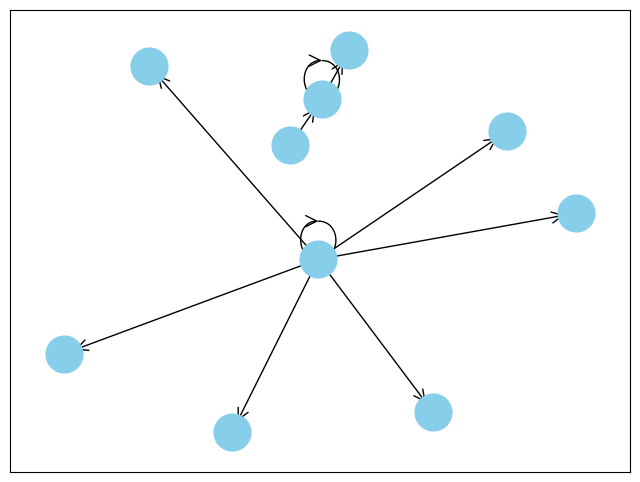

In [49]:
# plt.figure(figsize=(8, 6))
# pos = nx.spring_layout(G)  # positions for all nodes

# # Draw nodes
# nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')

# # Draw edges
# nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='->', arrowsize=20)

# len(list(nx.weakly_connected_components(G)))
